In [1]:
from geobed.fwd_collection.pyprop2pytorch import * 
    
from tqdm import tqdm

import torch
import torch.distributions as dist
 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up physical model, possible receiver locations and timeseries parameters

In [2]:
# Set up physical model, possible receiver locations and timeseries parameters
# subsurface model parameters
layers = [(5.0,2.5, 1.4, 2.5),
          (10, 4.0, 2.5, 3.0),
          (np.inf, 4.0, 2.5, 3.0)]

# Receiver parameters
grid_x          = torch.linspace(-100, 100, 10)
grid_y          = torch.linspace(-100, 100, 10)

design_space_X, design_space_Y = torch.meshgrid( grid_x, grid_y, indexing='ij')
design_space_x = design_space_X.flatten()
design_space_y = design_space_Y.flatten()
design_space_z = torch.zeros_like(design_space_x)

receivers  = np.vstack((design_space_x, design_space_y)).T
n_rec = receivers.shape[0]

# Source parameters
source_location = np.array([0.0, 0.0, 7])
source_time     = 0

# Timeseries parameters
t_0 = 0
t_N = 200
n_t = 60

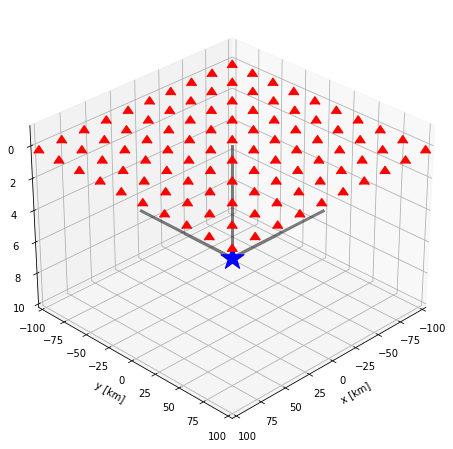

In [3]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    design_space_x.numpy(), design_space_y.numpy(), design_space_z.numpy(),
    marker=6, color='r', s=100, alpha=1.0)

ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_zlabel('z [km]')

xlim = (grid_x.min().item(), grid_x.max().item())
ylim = (grid_y.min().item(), grid_y.max().item())
zlim = (-1, 10)

ax.set_xlim( xlim )
ax.set_ylim( ylim )
ax.set_zlim( zlim )
ax.invert_zaxis()

ax.plot([0, 0], [0, 0], [0, source_location[2]], color='k', linewidth=3, alpha=0.5)
ax.plot([0, xlim[0]], [0, 0], [source_location[2], source_location[2]], color='k', linewidth=3, alpha=0.5)
ax.plot([0, 0], [0,  xlim[0]], [source_location[2], source_location[2]], color='k', linewidth=3, alpha=0.5)

ax.scatter(
    [source_location[0],], [source_location[1],], [source_location[2],],
    marker='*', color='b', s=600, alpha=1.0)


ax.view_init(30, 45)
# mt = [0.91, -0.89, -0.02, 1.78, -1.55, 0.47]
# ax.add_collection(beach(mt, size=200, linewidth=2, facecolor='b', axes=ax, zorder=10))

plt.show()

#  Set up MT prior

In [4]:
# dimensions are strike,  dip, rake, M0 
# M0 is scaled to 1e6NM to make matrix stable
DC_means = torch.tensor( ( 90.0, 45.0, 180.0, 1e6))
DC_covs  = torch.tensor( ( 20.0, 20.0,  20.0, 0.1))

prior_dist_DC = dist.MultivariateNormal(DC_means, torch.diag(DC_covs)**2) 

n_prior = int(1e4)

prior_samples_DC = prior_dist_DC.sample((n_prior,))
prior_samples_MT = dc2mt(prior_samples_DC)

# Calculate EIG using the DN method

In [5]:
data_std = 1e-1
def likelihood(data, name_list, d_dicts):   
    return dist.Independent(dist.Normal(data, data_std), 1)

In [6]:
design_dicts = {}

def forward_function(design):
    return MT_Lookup_Class(layers, design, source_location, source_time, n_t, t_0, t_N, derivatives=False, output_type='vel').forward

name_list = [str(i) for i in range(n_rec)]

for i, rec in enumerate(receivers):
    design_dicts[str(i)] = {'name': str(i), 'cost':0, 'x': rec[0], 'y': rec[1], 'z': 0.0, 'forward_function': forward_function, 'components': ['x', 'y', 'z'], 'n_t': n_t}
    

In [7]:
def constructor_1to1_design(temp_name_list, design_meta_data, prior_samples):

    temp_name_list = list(set(temp_name_list)) # remove duplicates 
    design_meta_list = [design_meta_data[n] for n in temp_name_list]
    
    n_prior = prior_samples.shape[0]
        
    receivers = np.array([(d_meta['x'], d_meta['y']) for d_meta in design_meta_list])
    
    data = torch.zeros((n_prior, len(temp_name_list), len(design_meta_list[0]['components']), design_meta_list[0]['n_t']))
        
    for i, d_meta in enumerate(design_meta_list):
        
        forward_function = d_meta['forward_function'](receivers[i][None, :])
        
        dat = forward_function(prior_samples).squeeze()
                
        data[:, i, :, :] = dat

    return data.flatten(start_dim=1)

In [8]:
from geobed.core import *

BED_Class = BED_discrete(
    design_dicts,
    likelihood,
    prior_samples=prior_samples_MT,
    design2data=constructor_1to1_design)

In [9]:
test_data = BED_Class.get_noisy_data(design=name_list[50:55])

In [10]:
design_list = [list([n,]) for n in name_list]

out = BED_Class.calculate_eig_parallel(5, design_list, method='dn')

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
eig_list = torch.tensor(out[0])

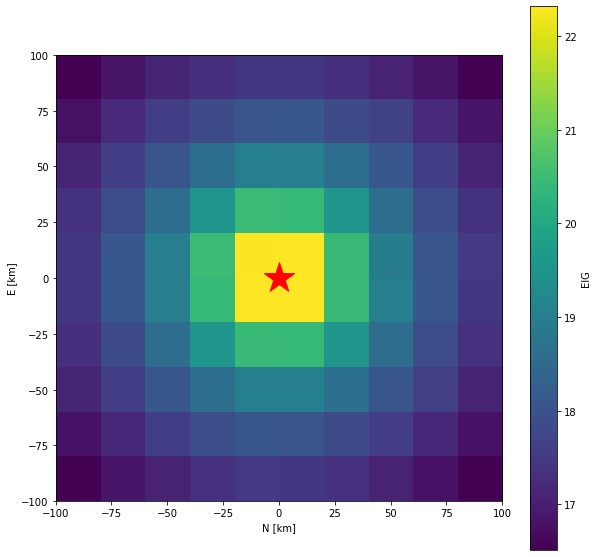

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
im = ax.imshow(eig_list.numpy().reshape(len(grid_x), len(grid_y)),
               extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], origin='lower')

ax.scatter([0,], [0,], marker='*', s=1000, color='r')

ax.set_xlabel('N [km]')
ax.set_ylabel('E [km]')

plt.colorbar(im, ax=ax, label='EIG')

plt.show()